In [ ]:
!pip install catboost
!pip install plotly
!pip install dtaidistance

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import plotly.graph_objects as go

In [ ]:
# Loading the datasets
btc_prices_df = pd.read_excel('/content/btc-usd-max.xls')
env_data_df = pd.read_excel('/content/BTC_Footprints_v1.xlsx')
# Removing duplicates
btc_prices_df.drop_duplicates(inplace=True)
env_data_df.drop_duplicates(inplace=True)
# Handling missing values
btc_prices_df.fillna(btc_prices_df.median(), inplace=True)
env_data_df.fillna(env_data_df.select_dtypes(include='number').mean(), inplace=True)
# correcting data types
btc_prices_df['Date'] = pd.to_datetime(btc_prices_df['Date'])
env_data_df['Date'] = pd.to_datetime(env_data_df['Date'])

# Handling missing values for numerical columns by replacing them with the median
btc_prices_df.fillna(btc_prices_df.median(numeric_only=True), inplace=True)

# Handling missing values for numerical columns in the environmental data by replacing them with the mean
# Make sure to convert dates properly
btc_prices_df['Date'] = pd.to_datetime(btc_prices_df['Date'])

In [ ]:
# Summary statistics
print(btc_prices_df.describe())
print(env_data_df.describe())

                      Date         price    market_cap  total_volume
count                 1127   1127.000000  1.127000e+03  1.127000e+03
mean   2019-09-15 00:00:00  11423.596535  2.074983e+11  2.254349e+10
min    2018-03-01 00:00:00   3216.627150  5.599852e+10  1.102263e+09
25%    2018-12-07 12:00:00   6564.718450  1.133980e+11  4.828316e+09
50%    2019-09-15 00:00:00   8508.499434  1.500940e+11  2.016173e+10
75%    2020-06-22 12:00:00  10532.868880  1.896050e+11  3.128715e+10
max    2021-03-31 00:00:00  61315.197930  1.145190e+12  1.788940e+11
std                    NaN  10828.189812  2.036104e+11  1.927343e+10
                                Date     BTCENEMAX     BTCENEMIN  \
count                           1127  1.127000e+03  1.127000e+03   
mean   2019-09-16 02:34:36.308784384  1.243140e+11  2.727782e+10   
min              2018-01-03 00:00:00  4.790000e+10  1.350000e+10   
25%              2018-12-07 12:00:00  8.310000e+10  1.880000e+10   
50%              2019-09-15 00:00:00  1

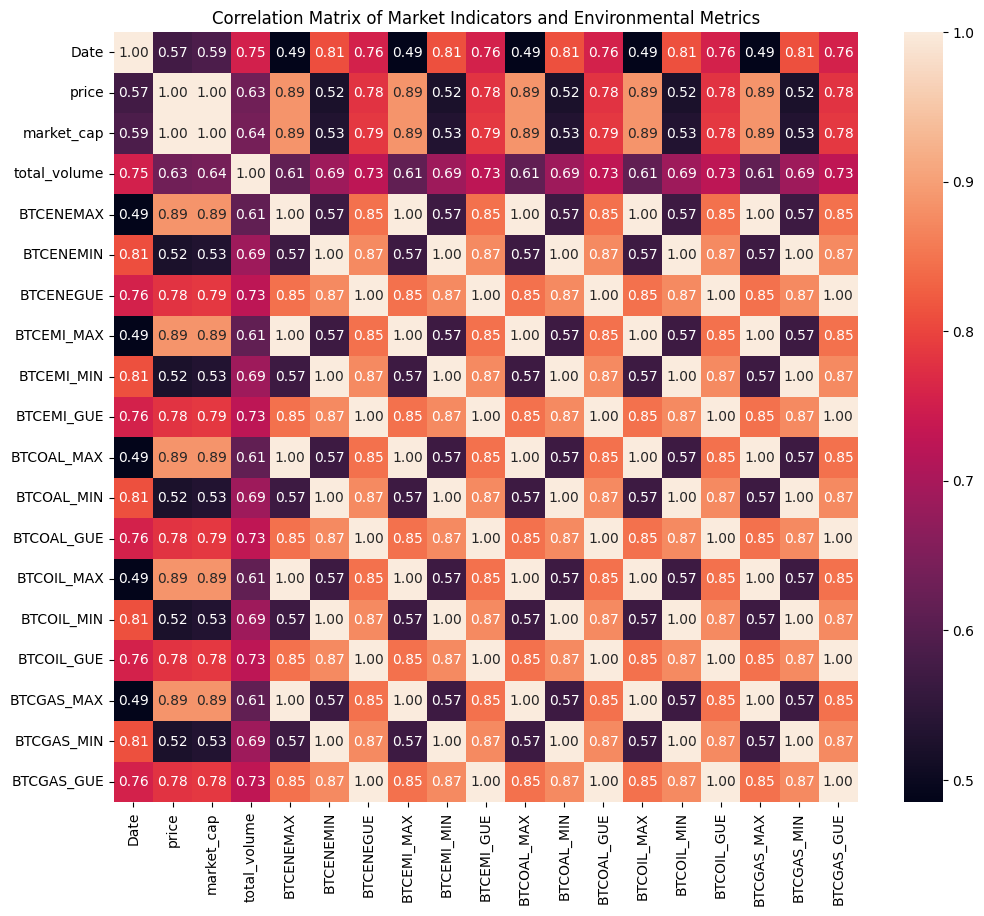

In [ ]:
combined_df = pd.merge(btc_prices_df, env_data_df, on='Date', how='inner')

# Calculate the correlation matrix for your combined dataset
correlation_matrix = combined_df.corr()

# Use seaborn to create a heatmap visualization of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Market Indicators and Environmental Metrics')
plt.show()

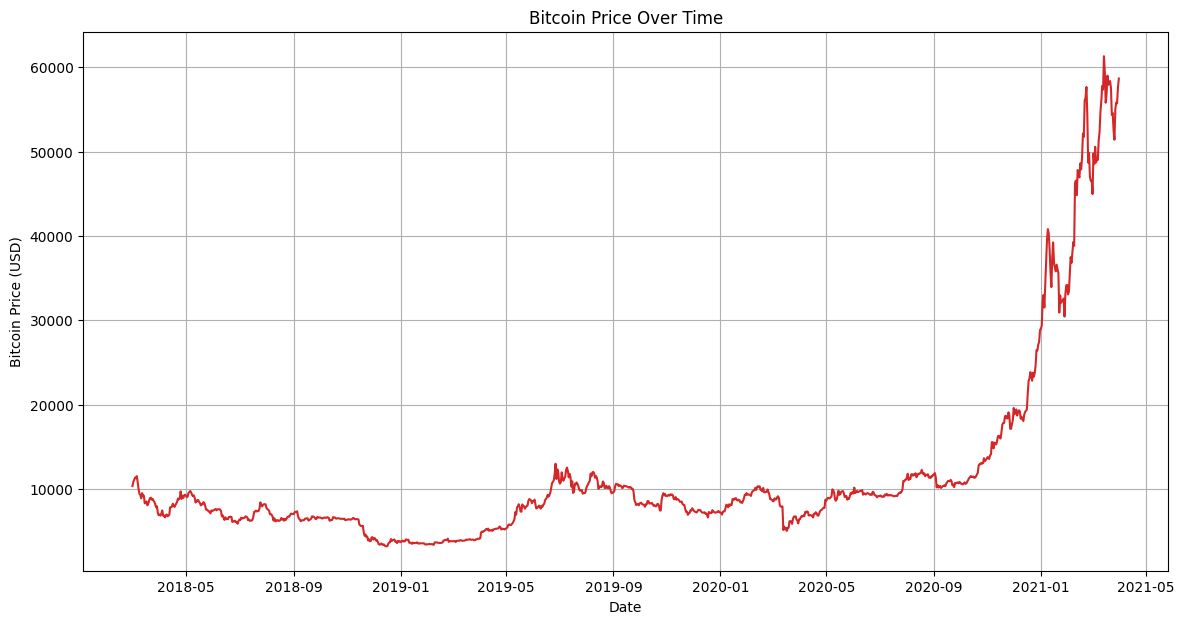

In [ ]:
# Graph 1: Bitcoin Price Over Time
plt.figure(figsize=(14, 7))
plt.plot(btc_prices_df['Date'], btc_prices_df['price'], color='tab:red')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Price Over Time')
plt.grid(True)
plt.show()

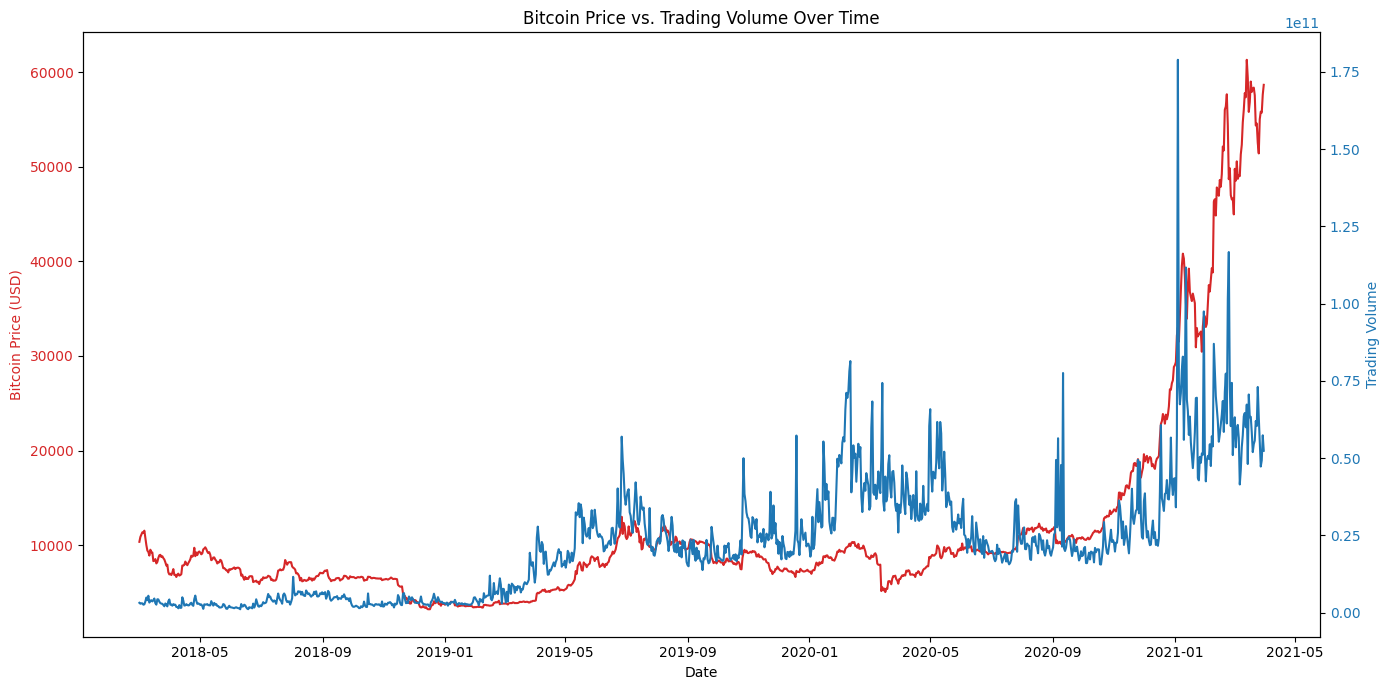

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Price (USD)', color=color)
ax1.plot(btc_prices_df['Date'], btc_prices_df['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Trading Volume', color=color)
ax2.plot(btc_prices_df['Date'], btc_prices_df['total_volume'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Bitcoin Price vs. Trading Volume Over Time')
fig.tight_layout()
plt.show()

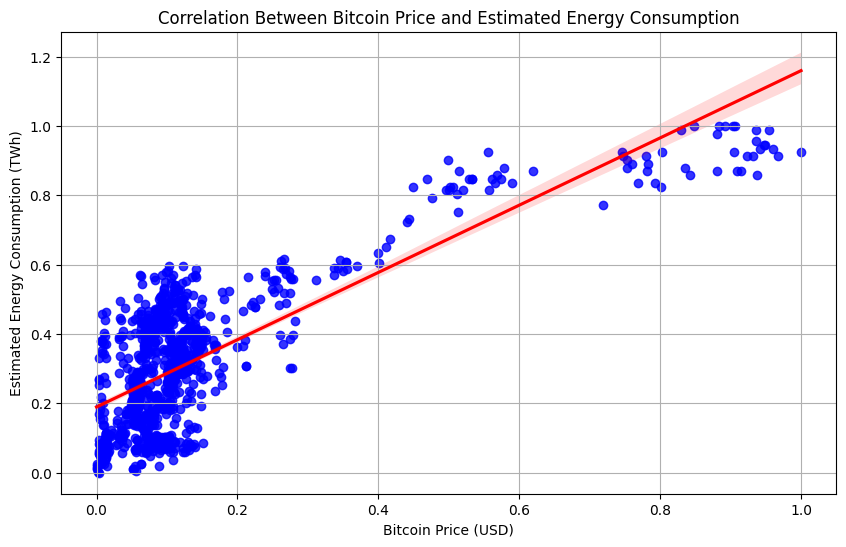

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='price', y='BTCENEGUE', data=combined_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Correlation Between Bitcoin Price and Estimated Energy Consumption')
plt.xlabel('Bitcoin Price (USD)')
plt.ylabel('Estimated Energy Consumption (TWh)')
plt.grid(True)
plt.show()

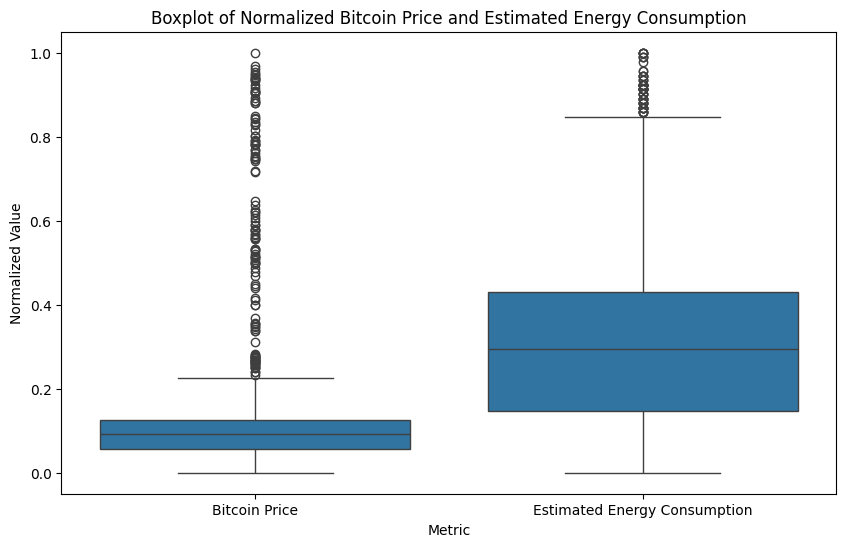

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Reshape data for scaling
btc_prices_scaled = scaler.fit_transform(btc_prices_df['price'].values.reshape(-1, 1))
env_energy_scaled = scaler.fit_transform(env_data_df['BTCENEGUE'].values.reshape(-1, 1))
# Create a DataFrame for plotting
data_for_plot = pd.DataFrame({
    "Bitcoin Price": btc_prices_scaled.flatten(),
    "Estimated Energy Consumption": env_energy_scaled.flatten()
})
# Melting the DataFrame to long format for seaborn boxplot
data_long = data_for_plot.melt(var_name='Metric', value_name='Normalized Value')
# Creating the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Normalized Value', data=data_long)
plt.title('Boxplot of Normalized Bitcoin Price and Estimated Energy Consumption')
plt.show()

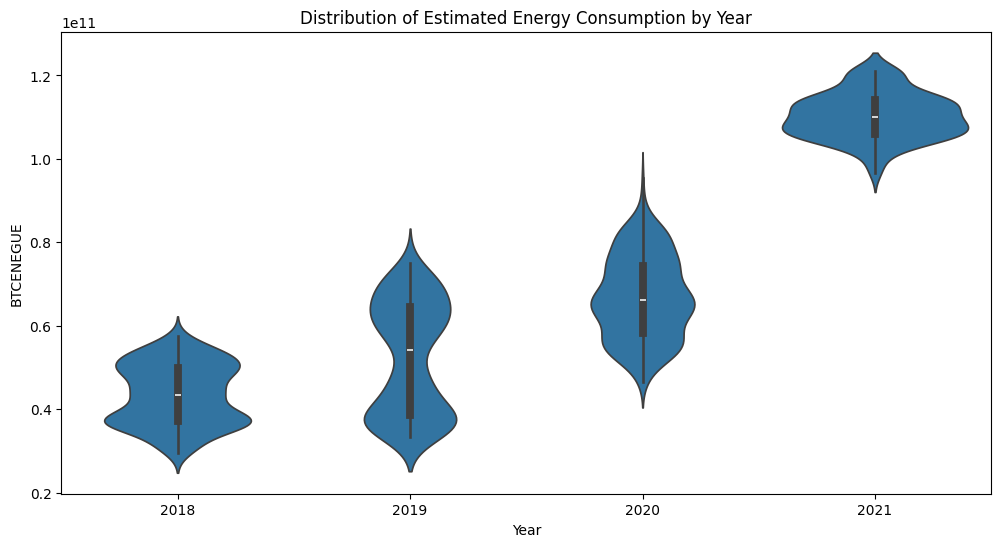

In [ ]:
# Extract year from date for both datasets
btc_prices_df['Year'] = btc_prices_df['Date'].dt.year
env_data_df['Year'] = env_data_df['Date'].dt.year

# Violin plot for energy consumption by year
plt.figure(figsize=(12, 6))
sns.violinplot(x='Year', y='BTCENEGUE', data=env_data_df)
plt.title('Distribution of Estimated Energy Consumption by Year')
plt.show()


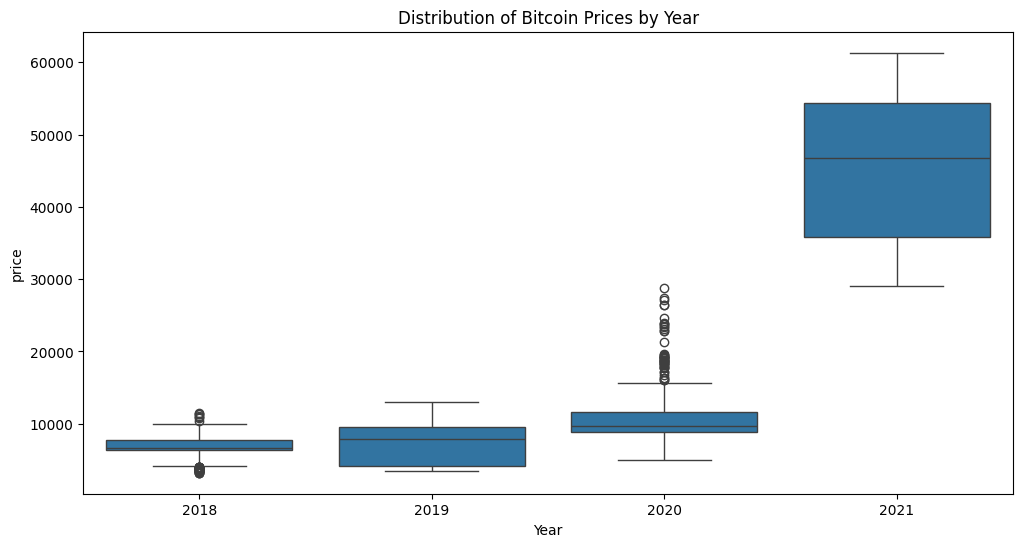

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='price', data=btc_prices_df)
plt.title('Distribution of Bitcoin Prices by Year')
plt.show()


In [ ]:
# Labels for each node in the Sankey diagram
labels = ['Coal', 'Oil', 'Natural Gas', 'CO2 Emissions', 'Other Emissions']

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Energy Source to Emissions Flow for Bitcoin Mining", font_size=10)
fig.show()

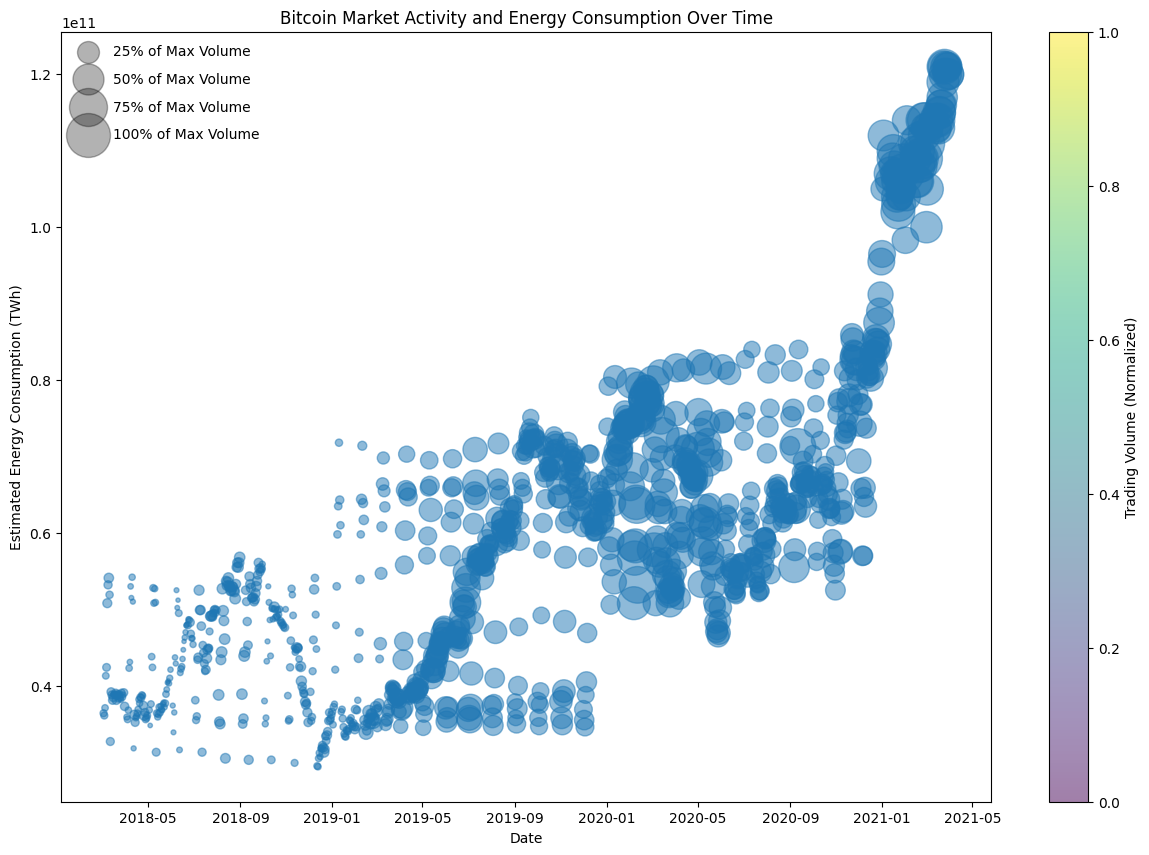

In [ ]:
# Merging the two dataframes on Date
combined_df = pd.merge(btc_prices_df, env_data_df, how='inner', on='Date')

# Normalize the 'total_volume' column for bubble size so it's easier to visualize
max_volume = combined_df['total_volume'].max()
combined_df['normalized_volume'] = combined_df['total_volume'] / max_volume * 1000  # Scale for visibility

# Create the plot
plt.figure(figsize=(15, 10))

# Scatter plot for dates and energy consumption with bubble size based on trading volume
plt.scatter(combined_df['Date'], combined_df['BTCENEGUE'], s=combined_df['normalized_volume'], alpha=0.5)

plt.title('Bitcoin Market Activity and Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Estimated Energy Consumption (TWh)')
plt.colorbar(label='Trading Volume (Normalized)')

# Displaying the bubble sizes as a reference
for volume in [0.25, 0.5, 0.75, 1.0]:
  plt.scatter([], [], c='k', alpha=0.3, s=(volume * max_volume / max_volume * 1000),
                label=str(int(volume * 100)) + '% of Max Volume')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

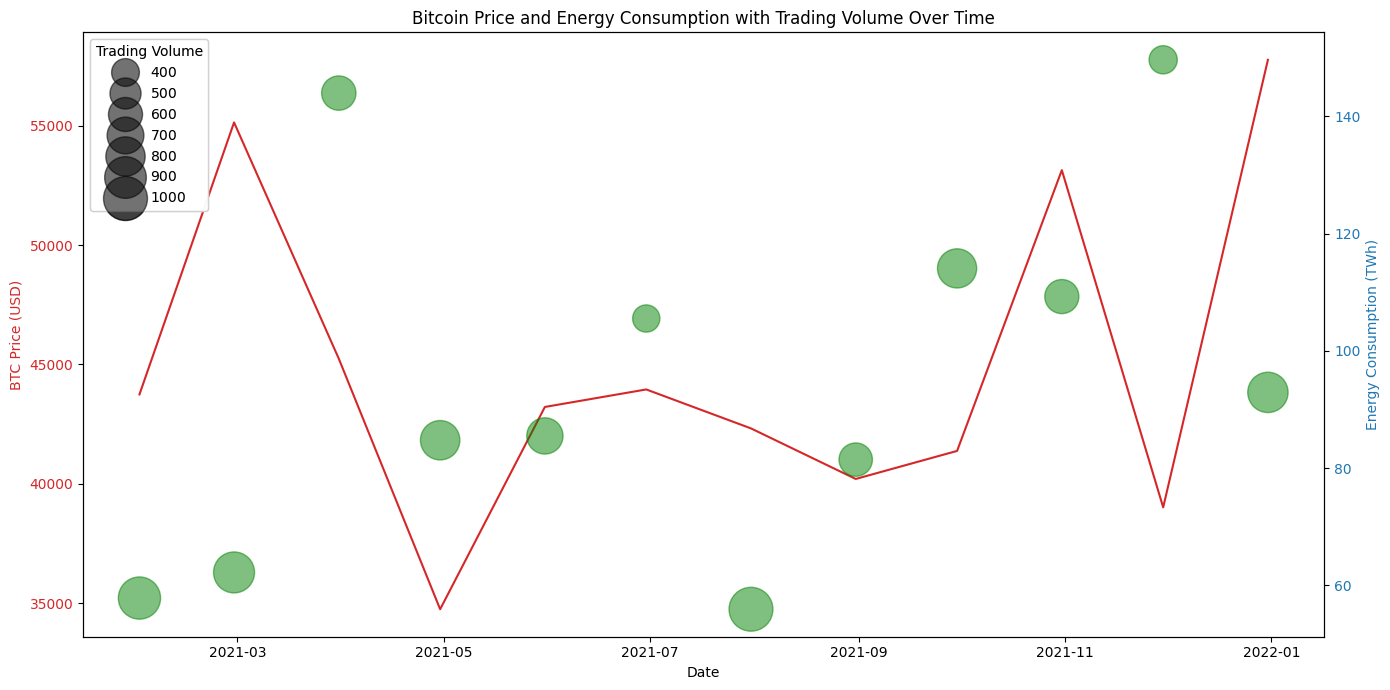

In [ ]:
# dates
dates = pd.date_range(start="2021-01-01", end="2021-12-31", freq="M")

# Sample Bitcoin prices and volume
btc_prices = np.random.uniform(low=30000, high=60000, size=len(dates))
btc_volume = np.random.uniform(low=50000, high=200000, size=len(dates))

# Sample energy consumption
energy_consumption = np.random.uniform(low=50, high=150, size=len(dates))

# Create a DataFrame
df = pd.DataFrame({
    'Date': dates,
    'BTC_Price': btc_prices,
    'BTC_Volume': btc_volume,
    'Energy_Consumption': energy_consumption
})

# Normalize the 'BTC_Volume' column for bubble size so it's easier to visualize
max_volume = df['BTC_Volume'].max()
df['Normalized_Volume'] = df['BTC_Volume'] / max_volume * 1000  # Scale for visibility

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color)
ax1.plot(df['Date'], df['BTC_Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Energy Consumption (TWh)', color=color)
scatter = ax2.scatter(df['Date'], df['Energy_Consumption'], s=df['Normalized_Volume'], c='green', alpha=0.5, label='Trading Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Legend for bubble sizes
legend1 = ax2.legend(*scatter.legend_elements("sizes", num=6), loc="upper left", title="Trading Volume")
ax2.add_artist(legend1)

plt.title('Bitcoin Price and Energy Consumption with Trading Volume Over Time')
plt.tight_layout()
plt.show()


In [ ]:
z_scores = np.abs(stats.zscore(combined_df['BTCENEGUE']))
data = combined_df[(z_scores < 3)]  # Adjust threshold as necessary

In [ ]:
combined_df['price_volatility'] = combined_df['price'].pct_change() * 100
combined_df['volatility_to_energy_ratio'] = combined_df['price_volatility'] / combined_df['BTCENEGUE']
#feature engineering

In [ ]:

scaler = StandardScaler()

# Scaling the 'price' feature from the Bitcoin prices dataset
combined_df['price_scaled'] = scaler.fit_transform(combined_df[['price']])

# Scaling the 'BTCENEGUE' feature from the environmental data dataset
combined_df['BTCENEGUE_scaled'] = scaler.fit_transform(combined_df[['BTCENEGUE']])
#feature scaling

In [ ]:
X = combined_df.drop('BTCENEGUE_scaled', axis=1)  # Features
y = combined_df['BTCENEGUE_scaled']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [ ]:
# Feature Engineering
combined_df['price_volatility'] = combined_df['price'].pct_change() * 100
combined_df['volatility_to_energy_ratio'] = combined_df['price_volatility'] / combined_df['BTCENEGUE']

# Handling infinite values
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with nan

# Scaling features
scaler = MinMaxScaler()
features_to_scale = ['price', 'BTCENEGUE', 'total_volume']
combined_df[features_to_scale] = scaler.fit_transform(combined_df[features_to_scale])

# Handling NaN values globally
imputer = SimpleImputer(strategy='median')
combined_df = pd.DataFrame(imputer.fit_transform(combined_df), columns=combined_df.columns)

# Prepare features and target variable
X = combined_df[['price', 'total_volume', 'price_volatility', 'volatility_to_energy_ratio']]
y = combined_df['BTCENEGUE']  # Adjust if 'BTCENEGUE' is not directly your target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models with a pipeline to handle any residual NaN values
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SGD Regressor': SGDRegressor(max_iter=1000, tol=1e-3),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    results[name] = (rmse, r2)

# results
for result in results:
    print(f"{result} - RMSE: {results[result][0]}, R^2: {results[result][1]}")


Linear Regression - RMSE: 0.12755744413633416, R^2: 0.5416927953227484
Ridge - RMSE: 0.12783893736939966, R^2: 0.5396677825540205
Lasso - RMSE: 0.19360393145526322, R^2: -0.05577995282870418
ElasticNet - RMSE: 0.19360397829171552, R^2: -0.05578046365503919
SGD Regressor - RMSE: 3.7445006062001197e+17, R^2: -3.9494159659503884e+36
Decision Tree - RMSE: 0.11714352786356544, R^2: 0.6134713721431143
Random Forest - RMSE: 0.08077598520661293, R^2: 0.8162151981115489
Gradient Boosting - RMSE: 0.07600623666654878, R^2: 0.8372790293052396


In [ ]:
# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Predict
lstm_predictions = lstm_model.predict(X_test)

# Calculate RMSE and R^2
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)

print("LSTM Model - RMSE:", lstm_rmse, "R^2:", lstm_r2)

Epoch 1/50
27/27 - 5s - loss: 0.1127 - val_loss: 0.0472 - 5s/epoch - 196ms/step
Epoch 2/50
27/27 - 0s - loss: 0.0492 - val_loss: 0.0265 - 141ms/epoch - 5ms/step
Epoch 3/50
27/27 - 0s - loss: 0.0308 - val_loss: 0.0169 - 141ms/epoch - 5ms/step
Epoch 4/50
27/27 - 0s - loss: 0.0205 - val_loss: 0.0113 - 136ms/epoch - 5ms/step
Epoch 5/50
27/27 - 0s - loss: 0.0143 - val_loss: 0.0080 - 157ms/epoch - 6ms/step
Epoch 6/50
27/27 - 0s - loss: 0.0107 - val_loss: 0.0062 - 262ms/epoch - 10ms/step
Epoch 7/50
27/27 - 0s - loss: 0.0087 - val_loss: 0.0051 - 313ms/epoch - 12ms/step
Epoch 8/50
27/27 - 0s - loss: 0.0076 - val_loss: 0.0046 - 244ms/epoch - 9ms/step
Epoch 9/50
27/27 - 0s - loss: 0.0067 - val_loss: 0.0042 - 306ms/epoch - 11ms/step
Epoch 10/50
27/27 - 0s - loss: 0.0062 - val_loss: 0.0039 - 227ms/epoch - 8ms/step
Epoch 11/50
27/27 - 0s - loss: 0.0057 - val_loss: 0.0036 - 105ms/epoch - 4ms/step
Epoch 12/50
27/27 - 0s - loss: 0.0054 - val_loss: 0.0035 - 92ms/epoch - 3ms/step
Epoch 13/50
27/27 - 0s -

In [ ]:
# Ensure lstm_predictions is flattened if it's not already 1-dimensional
lstm_predictions = lstm_predictions.flatten()

# Ensure y_test is a numpy array and flatten if necessary
y_test = np.array(y_test).flatten()

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

# Calculate R^2
lstm_r2 = r2_score(y_test, lstm_predictions)

# Calculate MAE
lstm_mae = mean_absolute_error(y_test, lstm_predictions)

# Calculate MAPE
lstm_mape = np.mean(np.abs((y_test - lstm_predictions) / y_test)) * 100

# Print the evaluation metrics
print("LSTM Model - RMSE:", lstm_rmse, "R^2:", lstm_r2, "MAE:", lstm_mae, "MAPE:", lstm_mape, "%")


LSTM Model - RMSE: 0.04982437637049288 R^2: 0.9300755900786778 MAE: 0.02621830342377821 MAPE: 12.59962402399898 %
